In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell

# Hyperparameters

In [2]:
sec_per_ar = 2
ar_per_sec = 1/sec_per_ar
time_length = 300
discount_rate = 0.95
rnn_size = 1
test_length = 700

# Load patient ar_data

In [3]:
folder_path = '/home/maestoj/medical_analysis/ar/'

In [4]:
def ar_data_load(patient_number,data_set_number):
    file_name = "data_patient_{}_AR{}.csv".format(patient_number,data_set_number)
    file_path = folder_path+file_name
    ar_file = open(file_path,'r',newline='')
    reader = csv.reader(ar_file, delimiter= ',')
    temp = []
    for row in reader:
        temp.append(row)
    temp = np.array(temp, dtype = np.float32)
    print("{} is loaded from {}".format(file_name, file_path))
    return temp

In [5]:
def ar_data_sum_channels(ar_datas):
    a, b = ar_datas.shape
    temp = np.zeros(b)
    for i in range(b):
        for j in range(a):
            temp[i] += ar_datas[j][i]
    return temp

In [6]:
def ar_data_select_channel(ar_datas, channel_number):
    return ar_datas[channel_number - 1]

In [7]:
def normalizer(array):
    temp_max = np.max(array)
    temp_min = np.min(array)
    temp = np.zeros(len(array))
    for i in range(len(array)):
        temp[i] = (array[i]-temp_min)/(temp_max-temp_min)
    return temp

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv


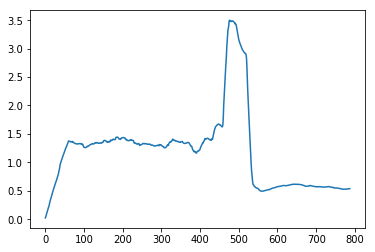

In [8]:
plt.plot(ar_data_sum_channels(ar_data_load(1,1)))
plt.show()

# Onset-time data

In [9]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [10]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1

for p in range(total_patient):
    temp = []
    for d in range(event_number[p]):
        temp.append(seizure_time_parser(onset_times_temp,p+1,d+1))
    onset_times.append(temp)

In [11]:
print("The number of datasets of patients")
print(event_number)
print("1st patient's seizure time for each data_set")
print(onset_times[0])
print("9th patient's seizure time for each data_set")
print(onset_times[8])

The number of datasets of patients
[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]
1st patient's seizure time for each data_set
[array([820]), array([781]), array([626]), array([713]), array([807]), array([792]), array([780])]
9th patient's seizure time for each data_set
[array([200]), array([312]), array([624]), array([762]), array([752]), array([772]), array([884]), array([502]), array([ 94, 258]), array([836]), array([650]), array([636]), array([576]), array([656]), array([638]), array([706])]


# Training_set

In [12]:
def train_set_generator(patient_number, dataset_number, channel_number):
    
    temp = normalizer(ar_data_select_channel(ar_data_load(patient_number, dataset_number), channel_number))
    
    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        


    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    
    onset_time_temp = onset_time_temp[0]
    print(onset_time_temp)
    
    if onset_time_temp*ar_per_sec < time_length:
        print("Wrong input")
        return
    
    input_data = np.zeros(time_length)
    output_data = np.zeros(time_length)
    for i in range(time_length):
        if i==0:
            output_data[time_length-1] = 1
        else :
            output_data[time_length-1-i] = discount_rate*output_data[time_length-i] 

    onset_on_ar = int(onset_time_temp*ar_per_sec)
    for i in range(time_length):
        input_data[i] = temp[onset_on_ar-time_length+1+i]

    return {'input' : input_data, 'output' : output_data}

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


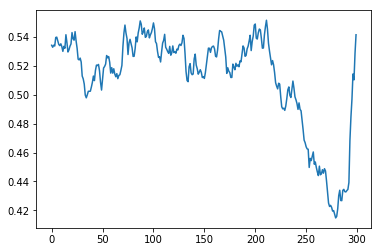

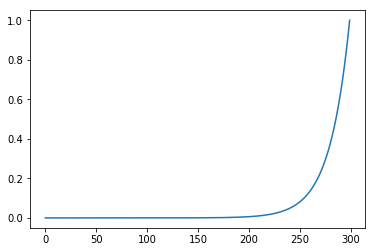

(300,)
(300,)


In [13]:
result = train_set_generator(1,1,1)
plt.plot(result['input'])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

# Neural network

In [14]:
x = tf.placeholder(tf.float32, shape=[time_length])
y = tf.placeholder(tf.float32, shape=[time_length])
test_x = tf.placeholder(tf.float32, shape=[test_length])

rnn_tei_x = tf.reshape(test_x,[test_length,1])
rnn_tei_x = tf.split(0,test_length,rnn_tei_x)

rnn_tri_x = tf.reshape(x,[time_length,1])
rnn_tri_x = tf.split(0,time_length,rnn_tri_x)

with tf.variable_scope("rnn") as scope:
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
    initial_state = lstm_cell.zero_state(1, tf.float32)
    outputs, states = rnn.rnn(lstm_cell, inputs = rnn_tri_x, initial_state = initial_state, dtype=tf.float32)
    scope.reuse_variables()
    test_outputs, test_states = rnn.rnn(lstm_cell, inputs = rnn_tei_x, initial_state = initial_state, dtype =tf.float32)

    temp_test_outputs = tf.reshape(tf.concat(1,test_outputs),[-1,1])
    temp_outputs = tf.reshape(tf.concat(1,outputs),[-1,1])
    temp_y = tf.reshape(y, [-1,1])
    print(temp_outputs)
    print(temp_y)

Tensor("rnn/Reshape_1:0", shape=(300, 1), dtype=float32)
Tensor("rnn/Reshape_2:0", shape=(300, 1), dtype=float32)


In [15]:
cost = tf.reduce_sum(tf.square(temp_outputs-temp_y))
train = tf.train.AdamOptimizer(1e-3).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
train_data_set = []
temp_train_data_set = [1,6,8,9,10,11,12,14,15,16,17,18]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,8,9,10,16,17]
train_data_set.append(temp_train_data_set)
print(train_data_set)

[[1, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18], [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21], [1, 8, 9, 10, 16, 17]]


data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


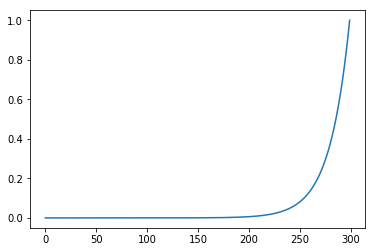

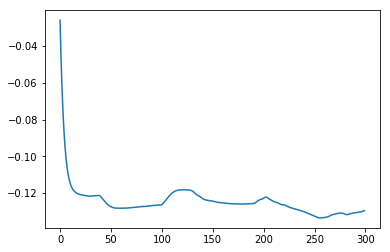

Cost = 20.164047241210938
Cost = 10.786693572998047
Cost = 9.392778396606445
Cost = 9.278980255126953
Cost = 9.24993896484375
Cost = 9.222233772277832
Cost = 9.1956787109375
Cost = 9.170442581176758
Cost = 9.146490097045898
Cost = 9.123682975769043
Cost = 9.101831436157227


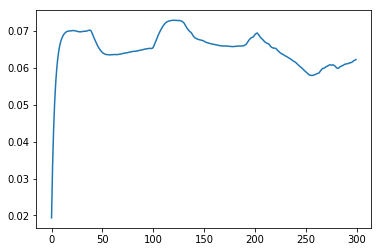

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


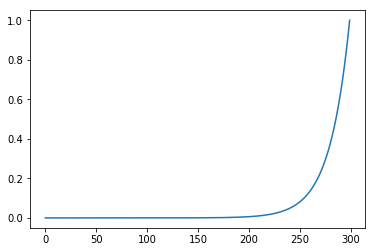

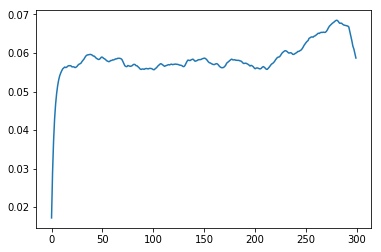

Cost = 8.698216438293457
Cost = 8.630232810974121
Cost = 8.57608413696289
Cost = 8.494363784790039
Cost = 8.343303680419922
Cost = 7.828042030334473
Cost = 8.054549217224121
Cost = 0.8626548647880554
Cost = 0.7484664916992188
Cost = 0.6747298836708069
Cost = 0.6096082925796509


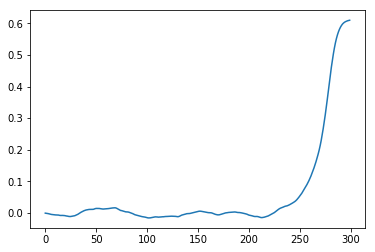

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


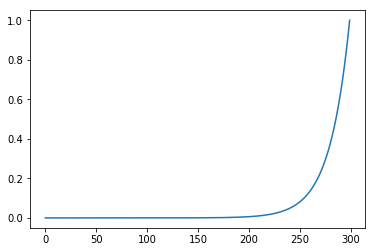

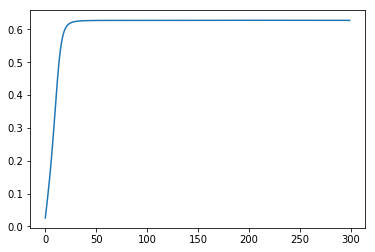

Cost = 98.32323455810547
Cost = 8.829326629638672
Cost = 8.680146217346191
Cost = 8.66250228881836
Cost = 8.652433395385742
Cost = 8.64274787902832
Cost = 8.631731033325195
Cost = 8.618631362915039
Cost = 8.602672576904297
Cost = 8.58271312713623
Cost = 8.556848526000977


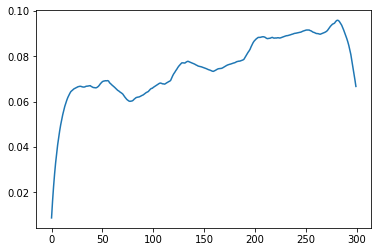

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


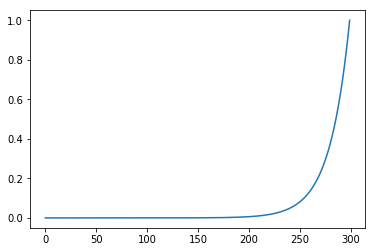

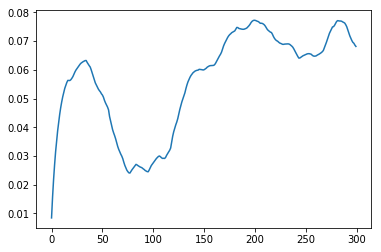

Cost = 8.433269500732422
Cost = 8.296072959899902
Cost = 8.246820449829102
Cost = 8.181440353393555
Cost = 8.069134712219238
Cost = 7.557276725769043
Cost = 2.0250353813171387
Cost = 1.992426872253418
Cost = 1.7741563320159912
Cost = 1.664952278137207
Cost = 1.5699431896209717


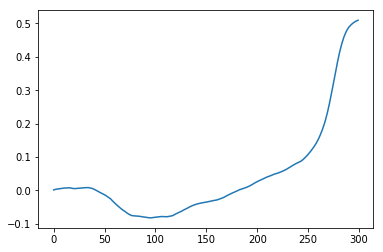

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


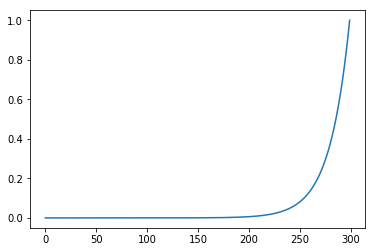

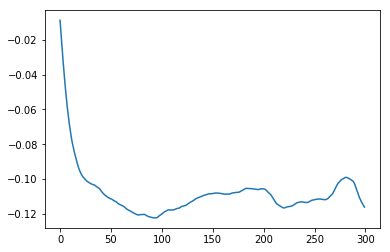

Cost = 18.111143112182617
Cost = 8.884778022766113
Cost = 3.185575246810913
Cost = 2.6555399894714355
Cost = 2.0212886333465576
Cost = 1.9405720233917236
Cost = 1.7718989849090576
Cost = 1.6486077308654785
Cost = 1.5606484413146973
Cost = 1.495318055152893
Cost = 1.4430698156356812


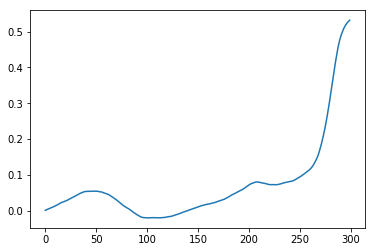

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


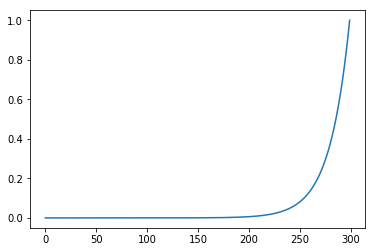

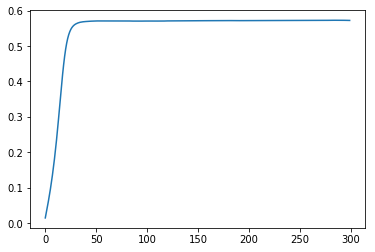

Cost = 79.67428588867188
Cost = 58.3582763671875
Cost = 41.72187805175781
Cost = 14.293895721435547
Cost = 8.208671569824219
Cost = 8.057358741760254
Cost = 7.999709129333496
Cost = 7.9578142166137695
Cost = 7.914629936218262
Cost = 7.862548828125
Cost = 7.7942657470703125


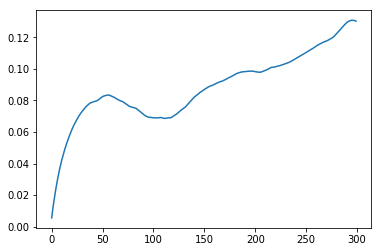

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


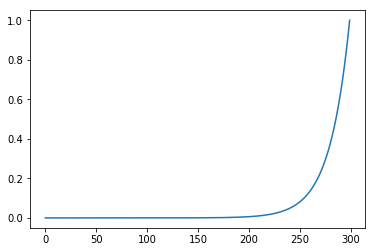

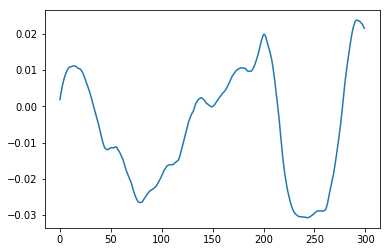

Cost = 10.062939643859863
Cost = 9.668560028076172
Cost = 9.279027938842773
Cost = 8.954477310180664
Cost = 8.708795547485352
Cost = 8.551334381103516
Cost = 8.471278190612793
Cost = 8.43815803527832
Cost = 8.424004554748535
Cost = 8.415425300598145
Cost = 8.408380508422852


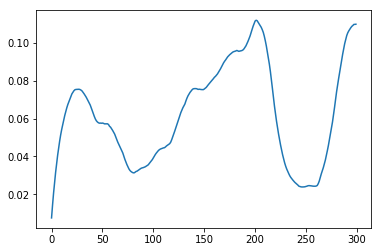

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


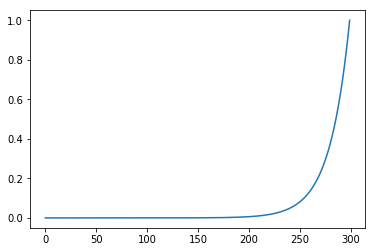

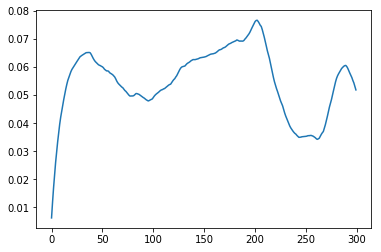

Cost = 9.126684188842773
Cost = 9.108896255493164
Cost = 9.098665237426758
Cost = 9.091025352478027
Cost = 9.084142684936523
Cost = 9.077615737915039
Cost = 9.071361541748047
Cost = 9.065362930297852
Cost = 9.059609413146973
Cost = 9.054092407226562
Cost = 9.048803329467773


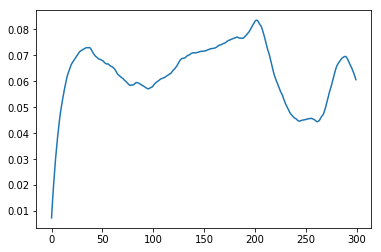

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


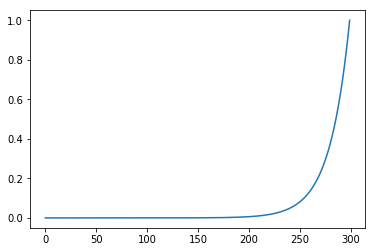

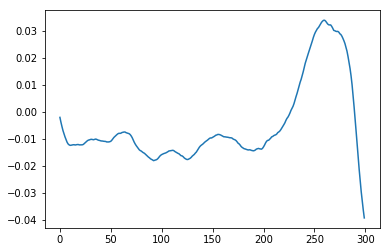

Cost = 10.213353157043457
Cost = 9.44974136352539
Cost = 8.575486183166504
Cost = 7.2109174728393555
Cost = 4.958935737609863
Cost = 2.7168164253234863
Cost = 2.147855281829834
Cost = 1.9704698324203491
Cost = 1.8493103981018066
Cost = 1.7366502285003662
Cost = 1.6255483627319336


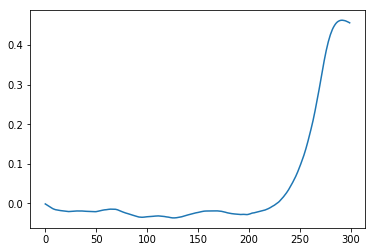

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


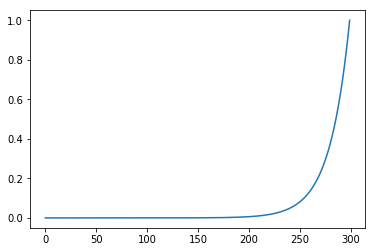

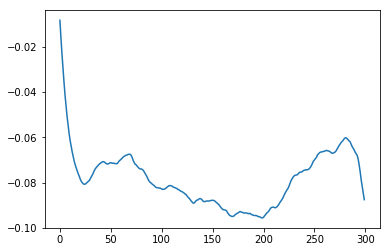

Cost = 14.936775207519531
Cost = 46.8260383605957
Cost = 7.895694732666016
Cost = 6.854708671569824
Cost = 6.538581848144531
Cost = 6.278310775756836
Cost = 6.089023590087891
Cost = 5.951088905334473
Cost = 5.838006973266602
Cost = 5.729643821716309
Cost = 5.612849712371826


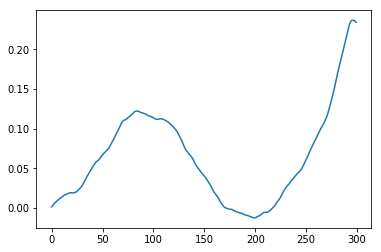

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


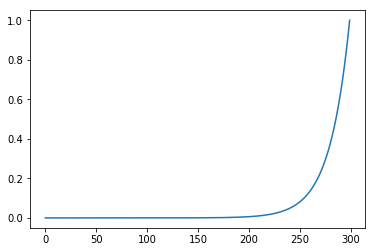

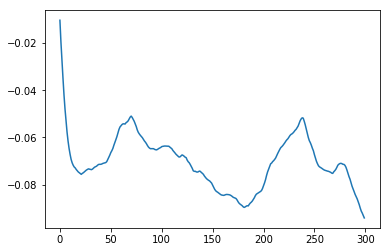

Cost = 14.971866607666016
Cost = 11.428522109985352
Cost = 10.068520545959473
Cost = 9.970830917358398
Cost = 9.9024658203125
Cost = 9.844217300415039
Cost = 9.793731689453125
Cost = 9.74936294555664
Cost = 9.709916114807129
Cost = 9.67449951171875
Cost = 9.64243221282959


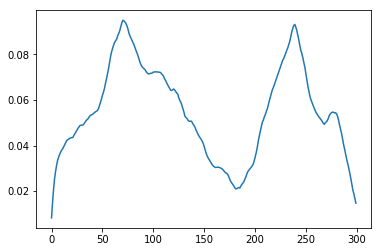

data_patient_1_AR1.csv is loaded from /home/maestoj/medical_analysis/ar/data_patient_1_AR1.csv
820


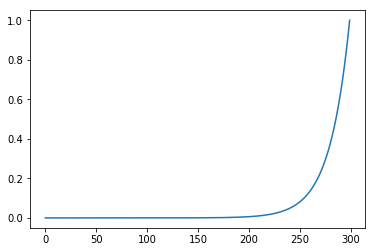

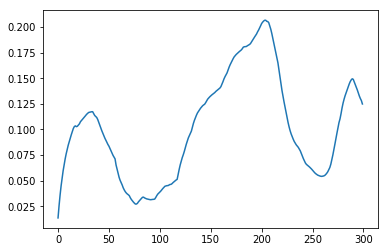

Cost = 9.399645805358887
Cost = 8.625205039978027
Cost = 8.618600845336914
Cost = 8.613248825073242
Cost = 8.608879089355469
Cost = 8.605291366577148
Cost = 8.602339744567871
Cost = 8.599902153015137
Cost = 8.597882270812988


In [ ]:
for a in range(len(train_data_set)):
    for b in range(len(train_data_set[a])):
        result = train_set_generator(1, a+1, b)
        input_data = result['input']
        output_data =result['output']
        plt.plot(output_data)
        plt.show()
        plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
        plt.show()
        for i in range(1001):
            opt, c = sess.run([train, cost], feed_dict={x: input_data, y: output_data})
            if i%100==0:
                print("Cost = {}".format(c))
        plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
        plt.show()

# Test_set_generator

In [ ]:
def test_set_generator(patient_number, dataset_number, channel_number):
    
    temp = normalizer(ar_data_select_channel(ar_data_load(patient_number, dataset_number), channel_number))

    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        
    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    onset_time_temp = onset_time_temp[0]
    print(onset_time_temp)
    input_data = np.zeros(test_length)
    time = np.zeros(test_length)
    for i in range(test_length):
        input_data[i] = temp[60+i]
        time[i] = (60+i)*sec_per_ar
    return {'input' : input_data, 'time' : time}

In [ ]:
result = test_set_generator(1, 1, 1)
input_data = result['input']
time =result['time']
plt.plot(time, input_data)
plt.show()
plt.plot(time, sess.run(temp_test_outputs, feed_dict = {test_x : input_data}))
plt.show()

In [ ]:
patient_number = 9
dataset_number = 5

temp = dataload(patient_number, dataset_number)
nchannels = temp.shape[0]
onset_times_temp = onset_times[patient_number-1][dataset_number-1]

flag = 0

for channel_number in range(nchannels):
    result = test_set_generator(temp,onset_times_temp,channel_number)
    val_input = result['input']
    val_output = result['output']

    if flag==0:
        flag=1
        time_step_size = striding/sampling_rate
        time = np.zeros(val_input.shape[0])
        for i in range(len(time)):
            time[i] = (i + data_size)*time_step_size   
        plt.plot(time, val_output)
        plt.title("Seizure_time_output(patient {}, event {})"
                    .format(patient_number,dataset_number))
        plt.set_xlabel('sec')
        plt.vlines(onset_times[patient_number-1][dataset_number-1],0,1.5, color='r'
                   , alpha=0.9, linestyle='--', label='Onsets')
        plt.show()

    prediction = sess.run(y_predict, feed_dict={x: val_input})
    plt.plot(time, prediction)
    plt.title("Prediction(patient {}, event {}, Channel {})"
                .format(patient_number,dataset_number,channel_number))
    plt.set_xlabel('sec')
    plt.show()